## table of contents
1. [libraries](#libraries)
2. [overall](#overall)
4. [gender](#gender)
5. [time](#time)
6. [product](#product)

_____
## libraries

In [29]:
from datetime import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import eda  # self developed package for eda

___
## overall

In [3]:
data = pd.read_csv('../raw/trainingData.csv', names=['sessionid', 'start', 'end', 'productid'])
label = pd.read_csv('../raw/trainingLabels.csv', names=['gender'])
data = data.assign(gender = label.gender)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sessionid  15000 non-null  object
 1   start      15000 non-null  object
 2   end        15000 non-null  object
 3   productid  15000 non-null  object
 4   gender     15000 non-null  object
dtypes: object(5)
memory usage: 586.1+ KB


,sessionid,start,end,productid,gender
0,u10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,female
1,u10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,female
2,u10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,female
3,u10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,female
4,u10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,female


It's always good to show (at least part of) the data and its shape. There are 15,000 rows x 5 columns. All columns are string types.

In [4]:
data.sessionid.nunique()

15000

Indeed, there are no duplicates of `sessionid`, i.e. it is the key of the data. 

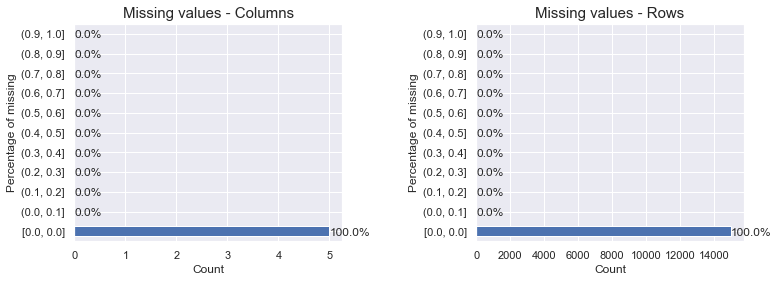

In [5]:
eda.count_missing_columns_rows(data)

There are no missing values.

___
## gender

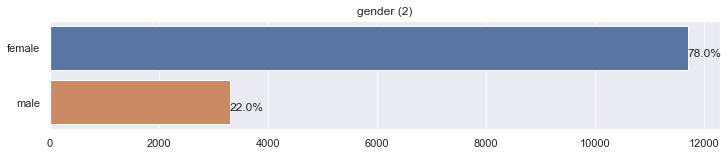

In [6]:
eda.countplot(data, columns=['gender'])

There are nearly 12,000 females (78%) and more than 3,000 males (22%) in the data set.

In [7]:
# convert label to 1 and 0
gender_dict = {'male': 1, 'female': 0}
data = data.assign(male = lambda df: df['gender'].replace(gender_dict))
data.head()

,sessionid,start,end,productid,gender,male
0,u10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,female,0
1,u10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,female,0
2,u10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,female,0
3,u10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,female,0
4,u10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,female,0


New column `male` is created.

___
## time

In [8]:
print(pd.to_datetime(data.start).describe(datetime_is_numeric=True))
print()
print(pd.to_datetime(data.end).describe(datetime_is_numeric=True))

count                            15000
mean     2014-12-05 00:28:56.088466688
min                2014-11-14 00:02:14
25%         2014-11-25 12:23:25.500000
50%                2014-12-06 19:05:26
75%                2014-12-15 20:40:49
max                2014-12-22 23:54:39
Name: start, dtype: object

count                            15000
mean     2014-12-05 02:39:17.391133440
min                2014-11-14 00:02:20
25%         2014-11-25 13:51:33.500000
50%         2014-12-06 20:39:51.500000
75%                2014-12-15 21:31:42
max                2014-12-22 23:54:43
Name: end, dtype: object


The data is about in one month, from mid November to mid December 2014.

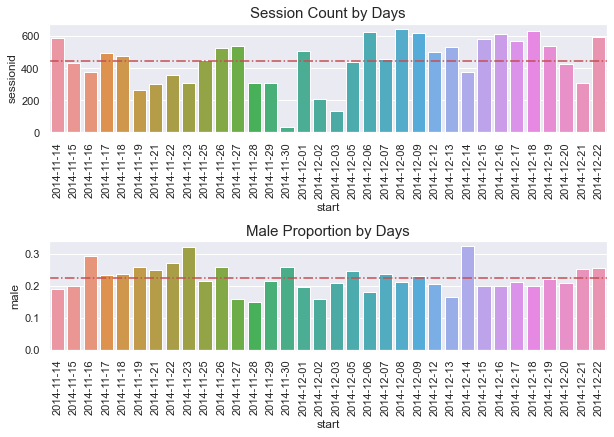

In [9]:
days = pd.to_datetime(data.start).dt.date
session = data.groupby(days).sessionid.count()
male = data.groupby(days).male.mean()

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.barplot(y=session, x=session.index,  order = days.value_counts().sort_index().index)
plt.axhline(y=session.mean(), color='r', linestyle='-.')
plt.xticks(rotation=90)
plt.title('Session Count by Days', size=15)


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=1)
sns.barplot(y=male, x=male.index,  order = days.value_counts().sort_index().index)
plt.axhline(y=male.mean(), color='r', linestyle='-.')
plt.xticks(rotation=90)
plt.title('Male Proportion by Days', size=15);

On average, there are 441 sessions in a day. The traffic is quite fluctuated. Some days get very few sessions such as 2014-11-30 and 2014-12-03.

Whereas, the gender proportion is more stable around 22% of the mean bar through out the days.

In [10]:
def gen_feat_time(data: pd.DataFrame) -> pd.DataFrame:
    """Generate features of time.

    Args:
        data (pd.DataFrame): Input data frame having sessionid, start and end columns.

    Returns:
        pd.DataFrame: Features of time.
    """
    feat_time = (
        data
        .set_index('sessionid')
        .loc[:, ['start', 'end']]
        .assign(start = lambda df: pd.to_datetime(df['start']))
        .assign(end = lambda df: pd.to_datetime(df['end']))

        .assign(duration = lambda df: (df['end'] - df['start']).dt.total_seconds())
        .assign(dayname = lambda df: df.start.dt.day_name())
        .assign(weekend = lambda df: df['dayname'].isin(['Saturday', 'Sunday']))
        .assign(worktime = lambda df: df['start'].dt.time.between(time(9, 0, 0), time(17, 0, 0)))
        .assign(worktime = lambda df: (df['weekend'] == 0) & (df['worktime'] == 1))
        .assign(nighttime = lambda df: df['start'].dt.hour.isin([22, 23, 0, 1, 2, 3, 4]))
        .assign(oclock = lambda df: df['start'].dt.minute.isin([55, 56, 57, 58, 59, 0, 1, 2, 3, 4]))

        .drop(['start', 'end'], axis=1)
    )
    feat_time['dayname'] = feat_time['dayname'].astype('category')
    feat_time[['duration', 'weekend', 'worktime', 'nighttime', 'oclock']] = (
        feat_time[['duration', 'weekend', 'worktime', 'nighttime', 'oclock']].astype(int))

    return feat_time

In [11]:
gen_feat_time(data)

,duration,dayname,weekend,worktime,nighttime,oclock
sessionid,,,,,,
u10001,6,Friday,0,0,1,1
u10002,1,Friday,0,1,0,0
u10003,839,Friday,0,0,1,1
u10004,2,Friday,0,0,1,0
u10005,197,Friday,0,0,1,0
...,...,...,...,...,...,...
u24996,231,Monday,0,0,1,0
u24997,68,Monday,0,0,1,0
u24998,2,Monday,0,0,1,1


Features are genderated from date and time. Will be used later in feature engineering and modelling.

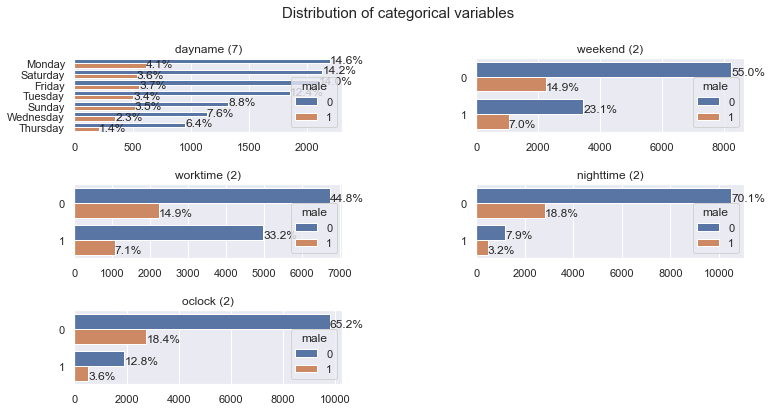

In [12]:
data_time = gen_feat_time(data).assign(male = data.set_index('sessionid').male)
eda.countplot(data_time, columns=['dayname', 'weekend', 'worktime', 'nighttime', 'oclock'], label='male', nclass=7)

The proportion of male/female in the generated time features. Though some features do not clearly separate well the genders, interaction between them in the model may help.

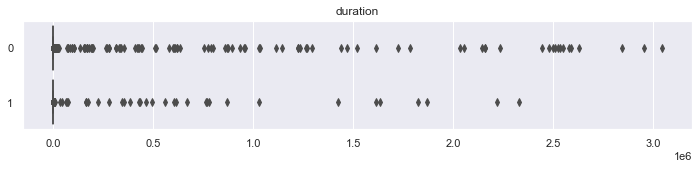

In [13]:
eda.boxplot(data_time, columns=['duration'], label='male')

There are some extreme values in `duration`. Some sessions are up to 3.e6 seconds (~ 34 days). The extreme values appear in both sessions of male and females. Next code will quantify the amount of the extreme values.

In [14]:
print(data_time.duration.describe())
print()
threshold = 60*60
(data_time.duration <= threshold).value_counts(normalize=True)


count    1.500000e+04
mean     7.821303e+03
std      1.128470e+05
min      1.000000e+00
25%      5.000000e+00
50%      1.000000e+01
75%      1.280000e+02
max      3.045161e+06
Name: duration, dtype: float64



True     0.987933
False    0.012067
Name: duration, dtype: float64

Percentile 75% of `duration` is at 128 seconds, which is still reasonable. Let's assume every session more than 1 hour (60*60 seconds) is abnormal. This abnormality happens in 1.2% of the data. Given (1) the amount of abnormality is minor, (2) no additional information to confirm the abnormality is really error and (3) tree based model will be used later; the data will be kept as a whole.

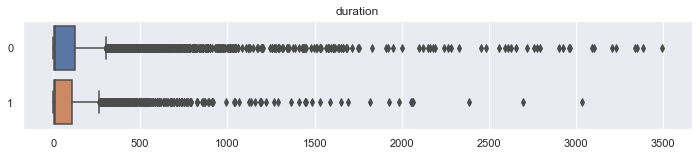

In [15]:
eda.boxplot(data_time.loc[lambda df: df['duration'] <= threshold], columns=['duration'], label='male')

Even if the abnormal values (greater than 1 hour) are removed, there are still many values that lie far from the mass.

___
## product

In [16]:
def transform_product(data: pd.DataFrame) -> pd.DataFrame:
    """Separate four levels of productid into different columns.

    Args:
        data (pd.DataFrame): Data input.

    Returns:
        pd.DataFrame: Separated four levels of productid along with their sessions.
    """
    product_series = (
        data
        .productid
        .str
        .split(';', expand=True)
        .stack()
        .reset_index(level=1, drop=True)
        .str
        .split('/')
    )
    product_df = pd.DataFrame(product_series.to_list(), index=product_series.index)
    product_df.drop(4, axis=1, inplace=True)
    product_df.columns = [f'level{x}' for x in product_df.columns]
    product_df = (
        data
        .reset_index()
        .loc[:, ['index', 'sessionid']]
        .merge(product_df.reset_index(), how='left', on='index')
        .drop('index', axis=1)
    )
    return product_df

In [17]:
product_df = transform_product(data)
product_df

,sessionid,level0,level1,level2,level3
0,u10001,A00001,B00001,C00001,D00001
1,u10002,A00002,B00002,C00002,D24897
2,u10003,A00002,B00002,C00002,D00002
3,u10003,A00002,B00002,C00003,D00003
4,u10003,A00002,B00002,C00007,D00007
...,...,...,...,...,...
33450,u24997,A00002,B00002,C00007,D36051
33451,u24997,A00002,B00002,C00007,D36052
33452,u24998,A00002,B00002,C00007,D36054
33453,u24999,A00002,B00002,C00007,D08424


There are 33,455 products have been bought in 15,000 sessions.

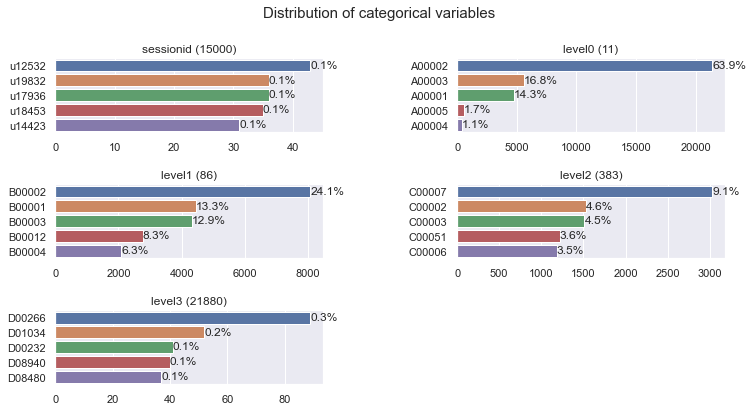

In [18]:
eda.countplot(product_df)

*(Number of unique value of variable is in the bracket next to the name.)*

There're 11 different `productid` in level0. `A00002` is account for 63.9%.

There're 86 different `productid` in level1. `B00002` is account for 24.1%.

There're 383 different `productid` in level2. `C00007` is account for 9.1%.

There're 21880 different `productid` in level3. `D00266` is account for 0.3%.

In [19]:
threshold = 100
for level in ['level0', 'level1', 'level2', 'level3']:
    count = product_df.groupby(level).sessionid.nunique()
    count_under_threshold = len(count.loc[lambda x: x>=threshold])
    print(f'----- {level}')
    print(f'total nunique: {product_df[level].nunique()}')
    print(f'appear in at least {threshold} sessions: {count_under_threshold}')
    print()

----- level0
total nunique: 11
appear in at least 100 sessions: 6

----- level1
total nunique: 86
appear in at least 100 sessions: 20

----- level2
total nunique: 383
appear in at least 100 sessions: 46

----- level3
total nunique: 21880
appear in at least 100 sessions: 0



Just a minor proportion of `productid` (at every level) appear in more than 100 sessions. Especially, all `productid` in `level3` appear in fewer than 100 sessions. So `level3` may be too detail to be a feature in machine learning model later on.

Following are code to keep only `productid` appear in more than 100 sessions, or have significant male proportion purchase (>0.5).

In [20]:
def keep_product(level: str, threshold: float = 0.5) -> list:
    """Generate list of productid to be kept at every level. A productid will
    be kept if being satisfied one of following two conditions:
    (1) Appear in more than 100 sessions.
        -> Keep the most common productid.
    (2) Appear in between 10 and 100 sessions and male proportion >= threshold
    (e.g. 0.5) in the sessions having the productid.
        -> Ignore uncommon productid, i.e. appear in fewer than 10 sessions.
        -> For productid neither common or uncommon, i.e. appear in between 10
        and 100 sessions, the productid will be kept only when it has male
        significant more than female compare to the population rate (0.22).

    Args:
        level (str): One of ['level0', 'level1', 'level2', 'level3']
        threshold (float, optional): [description]. Threshold apply to
            considering productid.Defaults to 0.5.

    Returns:
        list: productid to be kept.
    """
    product_df = transform_product(data)
    session_count = product_df.groupby(level).sessionid.nunique()
    product_keep = session_count.loc[lambda x: x > 100].index.to_list()    
    product_consider = session_count.loc[lambda x: (x >= 10) & (x <= 100)].index.to_list()
    product_add = (
        product_df
        .merge(data[['sessionid', 'male']], how='left', on='sessionid')
        .loc[lambda df: df[level].isin(product_consider)]
        .drop_duplicates(['sessionid', level])
        .groupby(level)
        .male
        .mean()
        .loc[lambda x: x>=threshold]
        .index
        .to_list()
    )
    product_keep.extend(product_add)
    return product_keep

In [21]:
def gen_feat_product(data: pd.DataFrame) -> pd.DataFrame:
    """Generate features product.

    Args:
        data (pd.DataFrame): Input data frame.

    Returns:
        pd.DataFrame: Features product.
    """
    product_df = transform_product(data)
    for level in ['level0', 'level1', 'level2', 'level3']:
        product_keep = keep_product(level)
        product_df[level].loc[lambda x: ~x.isin(product_keep)] = np.nan

    product_df = product_df.set_index('sessionid')
    feat_product = pd.get_dummies(product_df, prefix='', prefix_sep='')
    feat_product = feat_product.groupby('sessionid').sum()

    return feat_product

In [22]:
gen_feat_product(data)

,A00001,A00002,A00003,A00004,A00005,A00006,A00008,A00010,B00001,B00002,...,D07875,D10307,D13982,D14855,D18347,D18353,D22126,D33879,D35676,D35703
sessionid,,,,,,,,,,,,,,,,,,,,,
u10001,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
u10002,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
u10003,0,12,0,0,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0
u10004,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u10005,0,3,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u24996,0,3,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
u24997,0,4,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
u24998,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


There are 133 `productid` levels that either (1) appear in more than 100 sessions or (2) appear in between 10 and 100 sessions and have >50% of male purchases. This is the feature data frame that will be used later in model.

### bonus: `productid` does not strictly follow hierarchical structure: level0 > level1 > level2 > level3

In [23]:
# Some duplicates in level3 while having different values from level0 to level2
(
    product_df
    .drop('sessionid', axis=1)
    .drop_duplicates()
    .loc[lambda df: df.duplicated('level3', keep=False)]
    .sort_values('level3')
)

,level0,level1,level2,level3
3467,A00002,B00002,C00003,D00792
3698,A00002,B00002,C00002,D00792
623,A00002,B00001,C00059,D00900
3469,A00002,B00003,C00006,D00900
10624,A00002,B00002,C00009,D04760
20566,A00002,B00002,C00004,D04760
3482,A00002,B00003,C00006,D05263
3636,A00002,B00001,C00059,D05263
302,A00001,B00001,C00001,D05849
27169,A00001,B00001,C00019,D05849


In [24]:
# Some duplicates in level2 while having different values from level0 to level1
(
    product_df
    .drop(['sessionid', 'level3'], axis=1)
    .drop_duplicates()
    .loc[lambda df: df.duplicated('level2', keep=False)]
    .sort_values('level2')
)

,level0,level1,level2
1069,A00005,B00004,C00008
527,A00002,B00004,C00008
194,A00003,B00004,C00008
13,A00002,B00002,C00012
740,A00002,B00004,C00012
...,...,...,...
471,A00002,B00001,C00224
6201,A00001,B00015,C00276
1231,A00002,B00007,C00276
18702,A00003,B00080,C00372


In [25]:
# Some duplicates in level1 while having different values in level 0
(
    product_df
    .drop(['sessionid', 'level2', 'level3'], axis=1)
    .drop_duplicates()
    .loc[lambda df: df.duplicated('level1', keep=False)]
    .sort_values('level1')
)

,level0,level1
0,A00001,B00001
35,A00002,B00001
194,A00003,B00004
273,A00002,B00004
393,A00001,B00004
1069,A00005,B00004
28,A00002,B00011
9366,A00001,B00011


In [27]:
def transform_product_clean(data: pd.DataFrame) -> pd.DataFrame:
    """Separate four levels of productid into different columns. Every row the
    in the output dataframe is a unique combination of all four level ids.
    Ensure the hierarchical structure: level0 > level1 > level2 > level3.

    Args:
        productid (pd.DataFrame): Input data frame.

    Returns:
        pd.DataFrame: Separated four levels of productid.
    """
    product_df = transform_product(data)
    product_df = product_df.drop('sessionid', axis=1).drop_duplicates().reset_index(drop=True)
    product_level3 = (
        product_df
        .sort_values(['level0', 'level1', 'level2', 'level3'])
        .drop_duplicates('level3', keep='first')
    )
    product_level2 = (
        product_df
        .drop('level3', axis=1)
        .sort_values(['level0', 'level1', 'level2'])
        .drop_duplicates('level2', keep='first')
    )
    product_level1 = (
        product_df
        .drop(['level2', 'level3'], axis=1)
        .sort_values(['level0', 'level1'])
        .drop_duplicates('level1', keep='first')
    )
    product_df = (
        product_level1
        .merge(product_level2, how='left', on=['level0', 'level1'])
        .merge(product_level3, how='left', on=['level0', 'level1', 'level2'])
    )
    return product_df

In [28]:
transform_product_clean(data)

,level0,level1,level2,level3
0,A00001,B00001,C00001,D00001
1,A00001,B00001,C00001,D00075
2,A00001,B00001,C00001,D00080
3,A00001,B00001,C00001,D00081
4,A00001,B00001,C00001,D00087
...,...,...,...,...
16420,A00011,B00077,C00365,D35860
16421,A00011,B00077,C00370,D18882
16422,A00011,B00077,C00370,D34924
16423,A00011,B00077,C00401,D24701


Clean `productid` matrix that ensures hierarchical structure: `level0` > `level1` > `level2` > `level3`. This matrix has 16,425 rows, which is about 75% of the original unique number of `level3`.

___